In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import seaborn as sns
import scipy
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.graphics.api import interaction_plot, abline_plot
from statsmodels.stats.anova import anova_lm
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from operator import attrgetter
import nbconvert
import os
import sys
import nbconvert

### Accessing the data

Here, we access the dataset using the package pandas and convert the original .csv file to a pandas dataframe. Note that encoding has to be defined as 'cp1252'.

In [35]:
df=pd.read_csv("C:/Users/hanna/Documents/papers/UBC/Inputs/data_paper/data/final_record/final_record_16012023.csv", delimiter=';', encoding='cp1252')
df.head()

,id,original_id,data_collection_name,direction,means_of_transport,commodity_name,commodity_name_gen,commodity_category,quantity,unit,...,year,no_days,daytime,unit_quantity,total_quantity,daily_quantity,percent_missing_quantity,daily_quantity_adjusted_for_missing_locations,population,city
0,1,25030,Savelugu Customs barrier,out,Articulator,Rice (origin not specified),Rice,Cereal,808.0,Fertilizer sack,...,2014,6,night ...,50.00,40400.00,6733.333333,7.816320,7259.632199,312881,Tamale
1,2,7420,Yendi junction,out,Motorbike,Yam,Yam,"Root, tuber and plantain",1.0,Makola sack,...,2013,6,day ...,156.00,156.00,26.000000,5.059934,27.315583,312881,Tamale
2,3,6347,Yendi junction,in,Motorbike,Yam,Yam,"Root, tuber and plantain",0.5,Jute sack,...,2013,6,day ...,120.00,60.00,10.000000,5.059934,10.505993,312881,Tamale
3,4,9799,Tamale Aboabo Market,out,Handtruck,Onion,Onion,Vegetable,2.0,Fertilizer sack,...,2014,6,day ...,50.00,100.00,16.666667,7.540530,17.923422,312881,Tamale
4,5,9800,Tamale Aboabo Market,out,Handtruck,Cassava,Cassava,"Root, tuber and plantain",1.0,Makola sack,...,2014,6,day ...,128.18,128.18,21.363333,4.180956,22.256525,312881,Tamale


To create a subset of data containing inflows on the one hand and outflows on the other, we extract those rows with the source outside and the destination within the urban boundary for inflows, and vice versa for outflows.

In [36]:
df_incoming=df[(df["source_within_urban_boundary"] == "no") & (df["destination_within_urban_boundary"] == "yes")]
df_outgoing=df[(df["source_within_urban_boundary"] == "yes") & (df["destination_within_urban_boundary"] == "no")]

### Secondary data

Below, we take a look at the secondary data for Ouaga, which were added to the dataset. First, we show absolute and relative quantities of incoming products by railway. Second, we look at outgoing flows by plane.

In [37]:
# Ouaga secondary data
# Rail incoming
df_incoming_ouaga_or=df[(df["city"] == "Ouagadougou") & (df["source_within_urban_boundary"] == "no") & (df["destination_within_urban_boundary"] == "yes")]
df_incoming_ouaga=df_incoming_ouaga_or.copy()
df_incoming_ouaga.loc[df_incoming_ouaga['commodity_name_gen'] == 'Wheat flour', 'commodity_name_gen'] = 'Wheat'
df_incoming_ouaga_transport_rail=df_incoming_ouaga[(df_incoming_ouaga['means_of_transport']=='Rail')]
df_incoming_ouaga_transport_rail_sum=df_incoming_ouaga_transport_rail.groupby(['commodity_name_gen', 'season'], as_index=False)['daily_quantity_adjusted_for_missing_locations'].sum()
df_incoming_ouaga_transport_rail_sum['quantity_rail_kg_per_day']=df_incoming_ouaga_transport_rail_sum['daily_quantity_adjusted_for_missing_locations']
df_incoming_ouaga_transport_rail_sum_new=df_incoming_ouaga_transport_rail_sum.drop(columns='daily_quantity_adjusted_for_missing_locations')
df_incoming_ouaga_transport_all_sum=df_incoming_ouaga.groupby(['commodity_name_gen', 'season'], as_index=False)['daily_quantity_adjusted_for_missing_locations'].sum()
df_incoming_ouaga_merge=pd.merge(df_incoming_ouaga_transport_all_sum, df_incoming_ouaga_transport_rail_sum_new, on=['commodity_name_gen', 'season'], how='right')
df_incoming_ouaga_merge['rail_percent_of_total_incoming']=df_incoming_ouaga_merge['quantity_rail_kg_per_day']*100/df_incoming_ouaga_merge['daily_quantity_adjusted_for_missing_locations']
print(df_incoming_ouaga_merge)


  commodity_name_gen season  daily_quantity_adjusted_for_missing_locations  \
0            Cassava   lean                                    1000.000000   
1               Rice   lean                                  354562.171878   
2               Rice   peak                                  455976.234395   
3               Rice  rainy                                  936514.968379   
4              Wheat   lean                                   98666.666667   
5              Wheat   peak                                   96131.056681   
6              Wheat  rainy                                  255721.607322   

   quantity_rail_kg_per_day  rail_percent_of_total_incoming  
0               1000.000000                      100.000000  
1             188233.333333                       53.088950  
2             248766.666667                       54.556937  
3             290166.666667                       30.983666  
4              98666.666667                      100.000000  
5  

In [38]:
# Ouaga secondary data
# air outgoing

df_outgoing_ouaga_or=df[(df["city"] == "Ouagadougou") & (df["source_within_urban_boundary"] == "yes") & (df["destination_within_urban_boundary"] == "no")]
df_outgoing_ouaga=df_outgoing_ouaga_or.copy()
df_outgoing_ouaga_transport_air=df_outgoing_ouaga[(df_outgoing_ouaga['means_of_transport']=='Plane')]
df_outgoing_ouaga_transport_air_sum=df_outgoing_ouaga_transport_air.groupby(['commodity_name_gen', 'season'], as_index=False)['daily_quantity_adjusted_for_missing_locations'].sum()
df_outgoing_ouaga_transport_air_sum['quantity_air_kg_per_day']=df_outgoing_ouaga_transport_air_sum['daily_quantity_adjusted_for_missing_locations']
df_outgoing_ouaga_transport_air_sum_new=df_outgoing_ouaga_transport_air_sum.drop(columns='daily_quantity_adjusted_for_missing_locations')
df_outgoing_ouaga_transport_all_sum=df_outgoing_ouaga.groupby(['commodity_name_gen', 'season'], as_index=False)['daily_quantity_adjusted_for_missing_locations'].sum()
df_outgoing_ouaga_merge=pd.merge(df_outgoing_ouaga_transport_all_sum, df_outgoing_ouaga_transport_air_sum_new, on=['commodity_name_gen', 'season'], how='right')
df_outgoing_ouaga_merge['air_percent_of_total_outgoing']=df_outgoing_ouaga_merge['quantity_air_kg_per_day']*100/df_outgoing_ouaga_merge['daily_quantity_adjusted_for_missing_locations']
print(df_outgoing_ouaga_merge)


  commodity_name_gen season  daily_quantity_adjusted_for_missing_locations  \
0           Eggplant   lean                                     996.944391   
1           Eggplant   peak                                    1226.722985   
2           Eggplant  rainy                                    1773.263766   
3         Green bean   peak                                    3347.300000   
4          Groundnut   lean                                   15915.564322   
5          Groundnut   peak                                   10820.680185   
6              Mango   lean                                   18203.926557   

   quantity_air_kg_per_day  air_percent_of_total_outgoing  
0               826.333333                      82.886602  
1               891.500000                      72.673294  
2               641.333333                      36.166832  
3              3347.300000                     100.000000  
4               384.833333                       2.417969  
5              

### Fig. 5: Daily per capita inflows (in kg/cap/day) per food group 

Fig. 5 shows inflows for all four cities aggregated at the level of commodity category (or food group).

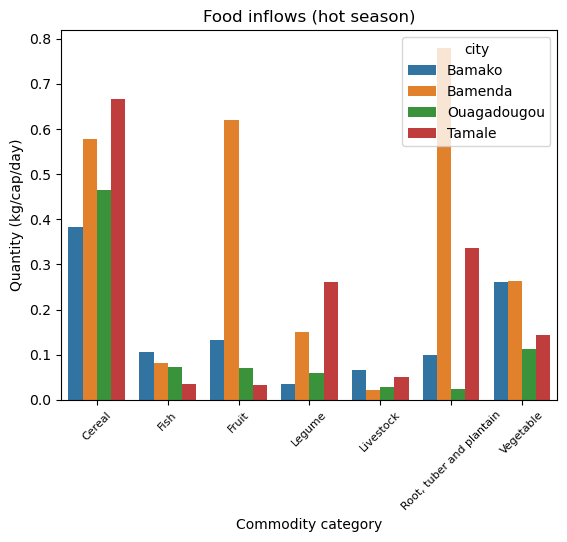

In [39]:
df_incoming_lean=df_incoming[((df_incoming['season']=='lean') & (df_incoming['city']=='Ouagadougou')) | ((df_incoming['season']=='lean') & (df_incoming['city']=='Bamako')) | ((df_incoming['season']=='lean') & (df_incoming['city']=='Bamenda')) | ((df_incoming['season']=='lean') & (df_incoming['year']==2014) & (df_incoming['city']=='Tamale'))]
df_incoming_lean_by_category=df_incoming_lean.groupby(['city', 'commodity_category', 'population'], as_index=False)['daily_quantity_adjusted_for_missing_locations'].sum()
df_incoming_lean_by_category['daily_per_capita_quantity']=df_incoming_lean_by_category['daily_quantity_adjusted_for_missing_locations']/df_incoming_lean_by_category['population']

sns.barplot(data=df_incoming_lean_by_category, x='commodity_category', y='daily_per_capita_quantity', hue='city')
plt.xticks(fontsize=8, rotation=45)
plt.ylabel('Quantity (kg/cap/day)',fontsize=10)
plt.xlabel('Commodity category',fontsize=10)
plt.title('Food inflows (hot season)')
plt.show()

### Fig. 6: In- and outflows in kg/day of maize in Tamale (peak season).

Fig. 6 plots sources and destinations of maize flows for Tamale (lean season 2014), where the symbol size reflects the absolute quantity (not adjusted by % missing locations). 
Note that we import the package pyproj to get the country delineation as a basemap. We need to change the directory as the package would otherwise access an existing, but older, version of pyproj in PostGIS.

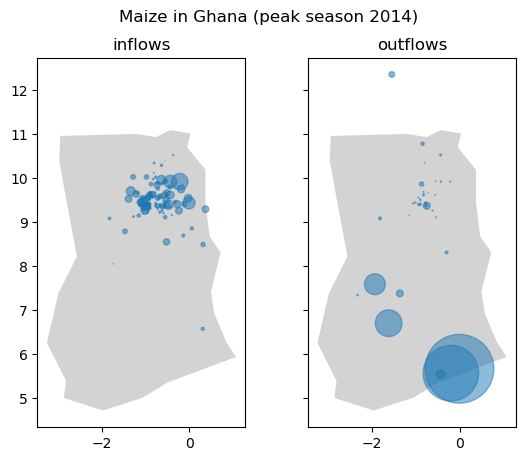

In [40]:
import pyproj

pyproj.datadir.set_data_dir("C:\\Users\\hanna\\anaconda3\\pkgs\\proj-9.1.0-heca977f_1\\Library\\share\\proj")

# Tamale & maize
df_tle_maize=df[(df['city']=='Tamale') & (df['commodity_name_gen']=='Maize')]
df_incoming_tle_maize=df_tle_maize[(df_tle_maize["source_within_urban_boundary"] == "no") & (df_tle_maize["destination_within_urban_boundary"] == "yes")]
df_incoming_tle_maize_peak=df_incoming_tle_maize[(df_incoming_tle_maize['season']=='peak') & (df_incoming_tle_maize['year']==2014)]

#inflows
daily_quantity_source_geo_sum_tle=df_incoming_tle_maize_peak.groupby(['city','commodity_name_gen', 'season', 'year', 'source_geometry'], as_index=False)['daily_quantity'].sum()

#outflows
df_outgoing_tle_maize=df_tle_maize[(df_tle_maize["source_within_urban_boundary"] == "yes") & (df_tle_maize["destination_within_urban_boundary"] == "no")]
df_outgoing_tle_maize_peak=df_outgoing_tle_maize[(df_outgoing_tle_maize['season']=='peak') & (df_outgoing_tle_maize['year']==2014)]
daily_quantity_destination_geo_sum_tle=df_outgoing_tle_maize_peak.groupby(['city','commodity_name_gen', 'season', 'year', 'destination_geometry'], as_index=False)['daily_quantity'].sum()

gpd.datasets.get_path("naturalearth_lowres")
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

daily_quantity_source_geo_sum_tle_cp=daily_quantity_source_geo_sum_tle.copy()
daily_quantity_destination_geo_sum_tle_cp=daily_quantity_destination_geo_sum_tle.copy()

daily_quantity_source_geo_sum_tle_cp.loc[:, 'geometry'] = daily_quantity_source_geo_sum_tle_cp.source_geometry.apply(wkt.loads)
daily_quantity_source_geo_sum_tle_cp.drop('source_geometry', axis=1, inplace=True) #Drop WKT column

daily_quantity_destination_geo_sum_tle_cp.loc[:, 'geometry'] = daily_quantity_destination_geo_sum_tle_cp.destination_geometry.apply(wkt.loads)
daily_quantity_destination_geo_sum_tle_cp.drop('destination_geometry', axis=1, inplace=True) #Drop WKT column

# Geopandas GeoDataFrame
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries[(countries["name"] == "Ghana")].plot(color="lightgrey", ax=ax1)
gdf1 = gpd.GeoDataFrame(daily_quantity_source_geo_sum_tle_cp, geometry='geometry')
gdf1['values'] = gdf1['daily_quantity']/100
gdf1.plot(alpha=0.5, k=5, markersize=gdf1['values'], ax=ax1)
ax1.set_title('inflows')

countries[(countries["name"] == "Ghana")].plot(color="lightgrey", ax=ax2)
gdf2 = gpd.GeoDataFrame(daily_quantity_destination_geo_sum_tle_cp, geometry='geometry')
gdf2['values'] = gdf2['daily_quantity']/100
gdf2.plot(alpha=0.5, k=5, markersize=gdf2['values'], ax=ax2, legend=True)
ax2.set_title('outflows')

plt.suptitle("Maize in Ghana (peak season 2014)")
plt.show()

### Fig. 7: Relative inflows of maize (in %) and number of maize source locations along a distance gradient 

Fig. 7 shows the quantity of maize (in % of total quantity) and number of maize sources (in counts) along a distance gradient aggregated at 10-km intervals. We see that Bamenda sources most of its maize supplies from many nearby sources, while Ouagadougou' major supplier is one city (Bobo-Dioulasso) at a distance of 330 km.

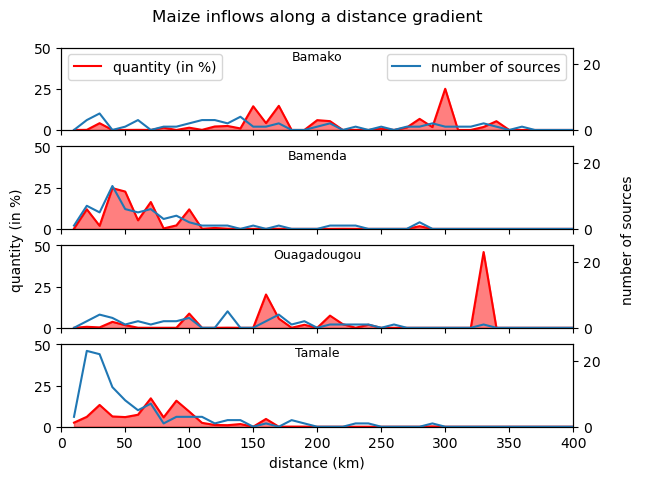

In [41]:
# aggregate at the level of node and compute percent of total quantity (lean season)
daily_quantity_sum=df_incoming_lean.groupby(['city','commodity_name_gen', 'season', 'year'], as_index=False)['daily_quantity'].sum()
daily_quantity_source_sum=df_incoming_lean.groupby(['city','commodity_name_gen', 'season', 'year', 'source_name', 'distance_to_source_km'], as_index=False)['daily_quantity'].sum()
df_incoming_by_node=pd.merge(daily_quantity_source_sum, daily_quantity_sum, how='left', on=['city', 'season', 'year', 'commodity_name_gen'])
df_incoming_by_node['percent_of_total_quantity']=df_incoming_by_node['daily_quantity_x']*100/df_incoming_by_node['daily_quantity_y']

# extract maize

df_incoming_by_node_maize=df_incoming_by_node[(df_incoming_by_node['commodity_name_gen']=='Maize')]

# distance interval
# aggregate values by 10 km intervals

max_distance=500
bins_10km=pd.interval_range(start=0.0, end=max_distance, freq=10)
df_10km=df_incoming_by_node_maize.copy()
df_10km['interval'] = pd.cut(df_10km.distance_to_source_km, bins=bins_10km.left)

# incoming daily quantities (in % of total quantities) per product and city

df_sum_10km=df_10km.groupby(['city', 'commodity_name_gen', 'interval'], as_index=False)['percent_of_total_quantity'].sum()
df_sum_10km['sum_quantity_percent_by_interval']=df_sum_10km['percent_of_total_quantity']
df_sum_10km[['left', 'right']] = [[x.left, x.right] for x in df_sum_10km['interval']]
df_count_10km=df_10km.groupby(['city', 'commodity_name_gen', 'interval'], as_index=False)['percent_of_total_quantity'].count()
df_count_10km['source_count']=df_count_10km['percent_of_total_quantity']
df_sum_count_10km=pd.merge(df_sum_10km, df_count_10km, how='left', on=['city', 'commodity_name_gen', 'interval'])

city_list=df_sum_count_10km['city'].unique().tolist()

fig, axs = plt.subplots(4, sharex=True)
fig.subplots_adjust(right=.9)
fig.subplots_adjust(left=.1)
fig.subplots_adjust(top=.9)

for count, city in enumerate(city_list):
    df_sum_count_10km_city=df_sum_count_10km[df_sum_count_10km['city']==city]

    distance=df_sum_count_10km_city['right']
    percent_quantity=df_sum_count_10km_city['sum_quantity_percent_by_interval']
    total_source_counts=df_sum_count_10km_city['source_count']

    lineplot1=sns.lineplot(x=distance, y=percent_quantity, ax=axs[count], color='red')
    lineplot1.fill_between(distance, percent_quantity, color='red',alpha=0.5)
    axs2 = axs[count].twinx()
    lineplot2=sns.lineplot(x=distance, y=total_source_counts, ax=axs2)
    axs[count].set_title(city, x=0.5, y=0.75, size=9)
    axs[count].set_xlim(0,400)
    axs[count].set_ylim(0,50)
    axs[count].set_xlabel('distance (km)')

    axs[count].axes.get_yaxis().get_label().set_visible(False)

    axs2.set_ylim(0,25)
    axs2.axes.get_yaxis().get_label().set_visible(False)

    axs[0].legend(['quantity (in %)'], loc=2)
    if count ==0:
        axs2.legend(['number of sources'], loc=1)

fig.supylabel('quantity (in %)', size=10)
fig.text(0.975, 0.5, 'number of sources', va='center', rotation='vertical', size=10)
fig.suptitle('Maize inflows along a distance gradient')
plt.show()


# to export as shp (for use in GIS programs)

#gdf1.to_file('C:\\Users\\hanna\\Documents\\papers\\UBC\\Outputs\\data_paper\\figures\\shp_Figure_6\\tle_maize_peak_in.GeoJSON', crs='EPSG:4326')
#gdf2.to_file('C:\\Users\\hanna\\Documents\\papers\\UBC\\Outputs\\data_paper\\figures\\shp_Figure_6\\tle_maize_peak_out.GeoJSON', crs='EPSG:4326')


### Transit flows

So far, we only looked at inflows and outflows. Transit flows, the third category of flows, are defined as having their source AND destination outside the urban area, i.e., they pass through the city without a stop. This means that transits flows should have been recorded twice, during entry and exit. This is why quantities are divided by 2. The Tamale-Bolagatanga road, however, was not covered in the night during the first survey in 2013. We account for that by not dividing affecting flows by 2 (those flows that were recorded on other roads).
We look at transit flows for tomato in Tamale during the lean season.

In [42]:
# transit flows for aggregated flows (individual flows divided by 2)

df_transits=df[(df["source_within_urban_boundary"] == "no") & (df["destination_within_urban_boundary"] == "no")]

df_transits_one_flow=df_transits.copy()
df_transits_two_flows=df_transits.copy()

# recorded once (peak season 2013 not covered during night on Tamale-Bolga road)

transits_one_flow_list=[3664, 1640, 1638, 1336, 1895, 1896, 1788, 1897, 1804, 1811, 4287, 1803, 1696, 1839, 1993, 1987, 1991, 1961, 1917, 3459, 1932, 1744, 1786, 1827, 1892, 1699, 1662, 1705, 1774, 1301, 1690, 1830, 1828, 1417, 1322, 1688, 1318, 1340, 1809, 1887, 1704, 1879, 1829, 1884, 1701, 1865, 1861, 1693, 1876, 1762, 1700, 1676, 1298, 1826, 1333, 1655, 1807, 1660, 1311, 3486, 1631, 1300, 1883, 1815, 1908, 1960, 1981, 1926, 1927, 1331, 1931, 1986, 1746, 1355]
df_transits_one_flow=df_transits_one_flow.loc[(df_transits_one_flow['city']=='Tamale') & (df_transits_one_flow['original_id'].isin(transits_one_flow_list))]
df_transits_one_flow.loc[:, 'daily_quantity_transits']=df_transits_one_flow.loc[:, 'daily_quantity_adjusted_for_missing_locations']

# recorded twice when incoming and outgoing

df_transits_two_flows=df_transits_two_flows.loc[((df_transits_two_flows['city']=='Tamale') & (~df_transits_two_flows['original_id'].isin(transits_one_flow_list))) | (df_transits_two_flows['city']!='Tamale')]
df_transits_two_flows.loc[:, 'daily_quantity_transits']=df_transits_two_flows.loc[:, 'daily_quantity_adjusted_for_missing_locations']/2
df_transits_sum=pd.concat([df_transits_one_flow, df_transits_two_flows])

# analysis
# extract crop, season and year

df_transits_sum_tomato_lean=df_transits_sum[(df_transits_sum['season']=='lean') & (df_transits_sum['year']==2014) & (df_transits_sum['commodity_name_gen']=='Tomato')].copy()
grp_df_transits_sum_tomato_lean=df_transits_sum_tomato_lean.groupby(by=['city', 'commodity_name_gen', 'source_name', 'destination_name'], as_index=False)['daily_quantity_transits'].sum()
df_transits_sum_tomato_lean_tle=grp_df_transits_sum_tomato_lean[grp_df_transits_sum_tomato_lean['city']=='Tamale']
df_transits_sum_tomato_lean_tle.head()
df_transits_sum_tomato_lean_tle_sel_columns=df_transits_sum_tomato_lean_tle[['source_name', 'destination_name', 'daily_quantity_transits']]
df_transits_sum_tomato_lean_tle_sel_columns.sort_values(by=['daily_quantity_transits'], ascending=False)


,source_name,destination_name,daily_quantity_transits
46,Burkina Faso,Accra,60357.973247
60,Burkina Faso,Kumasi,24265.151799
67,Burkina Faso,Takoradi,4021.284260
70,Burkina Faso,Techiman,4017.357224
63,Burkina Faso,Nkawkaw,2356.221246
59,Burkina Faso,Koforidua,2120.599121
43,Bolgatanga,Accra,2075.718717
75,Ouagadougou (Burkina Faso),Accra,2042.058413
79,Ouagadougou (Burkina Faso),Kumasi,1952.409805
82,Paga,Accra,1727.895580


### Technical validation

The following section contains the figures used for assessing the technical validation of the data.

year commodity_name_gen           2014          2015  variation_percent  \
0               Avocado    1446.964549    950.372637          34.319563   
2                Banana     403.155592   1399.652267        -247.174216   
3                  Bean    9639.601998  11899.255261         -23.441354   
5               Cassava    2901.394834   2736.758479           5.674386   
6                Cattle    1995.119051   1717.245533          13.927666   
..                  ...            ...           ...                ...   
135             Sorghum   10663.338422           NaN         -58.359271   
136             Soybean  107036.552164           NaN         -86.314613   
140              Tomato   13825.172806           NaN         -48.742607   
141          Watermelon   90792.959237           NaN        -305.772512   
143                 Yam  107771.859378           NaN         -91.211777   

year season_direction          2013  
0     Lean season out           NaN  
2     Lean season out  

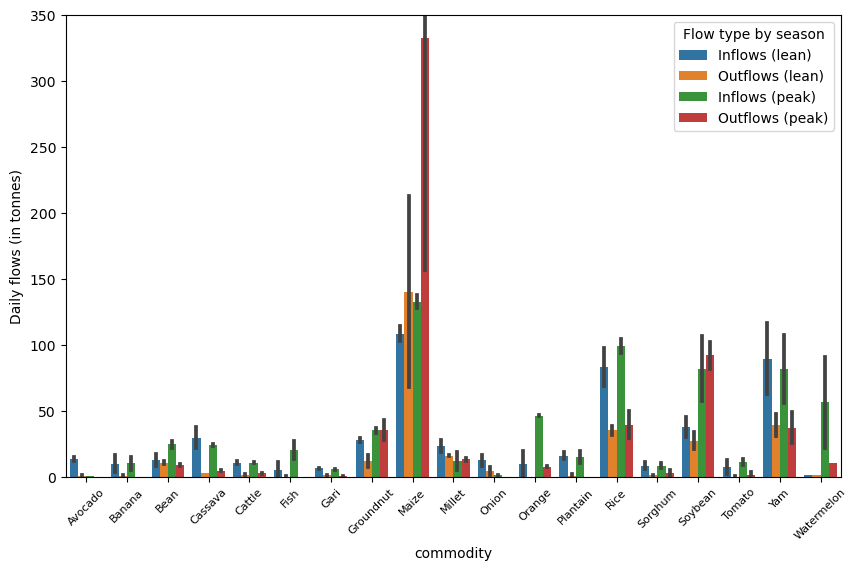

In [43]:
# comparing peak and lean season data (in and outflows) for Tamale
# preparing the data according to type of flow (in, out) and season

df_incoming_lean_tle= df_incoming[(df_incoming['season']=='lean') & (df_incoming['city']=='Tamale')]
df_incoming_lean_tle_agg=df_incoming_lean_tle.groupby(by=['city', 'season', 'year', 'commodity_name_gen'], as_index= False)['daily_quantity_adjusted_for_missing_locations'].sum()
df_incoming_lean_tle_agg_direction=df_incoming_lean_tle_agg.copy()
df_incoming_lean_tle_agg_direction['direction']='in'

df_incoming_peak_tle= df_incoming[(df_incoming['season']=='peak') & (df_incoming['city']=='Tamale')]
df_incoming_peak_tle_agg=df_incoming_peak_tle.groupby(by=['city', 'season', 'year', 'commodity_name_gen'], as_index= False)['daily_quantity_adjusted_for_missing_locations'].sum()
df_incoming_peak_tle_agg_direction=df_incoming_peak_tle_agg.copy()
df_incoming_peak_tle_agg_direction['direction']='in'

df_outgoing_lean_tle= df_outgoing[(df_outgoing['season']=='lean') & (df_outgoing['city']=='Tamale')]
df_outgoing_lean_tle_agg=df_outgoing_lean_tle.groupby(by=['city', 'season', 'year', 'commodity_name_gen'], as_index= False)['daily_quantity_adjusted_for_missing_locations'].sum()
df_outgoing_lean_tle_agg_direction=df_outgoing_lean_tle_agg.copy()
df_outgoing_lean_tle_agg_direction['direction']='out'

df_outgoing_peak_tle= df_outgoing[(df_outgoing['season']=='peak') & (df_outgoing['city']=='Tamale')]
df_outgoing_peak_tle_agg=df_outgoing_peak_tle.groupby(by=['city', 'season', 'year', 'commodity_name_gen'], as_index= False)['daily_quantity_adjusted_for_missing_locations'].sum()
df_outgoing_peak_tle_agg_direction=df_outgoing_peak_tle_agg.copy()
df_outgoing_peak_tle_agg_direction['direction']='out'

# annual variation

incoming_lean_tle_variation=df_incoming_lean_tle_agg_direction.pivot(index='commodity_name_gen', columns='year', values='daily_quantity_adjusted_for_missing_locations')
incoming_lean_tle_variation['variation_percent']=(incoming_lean_tle_variation[2014]-incoming_lean_tle_variation[2015])*100/incoming_lean_tle_variation[2014]
incoming_lean_tle_variation['season_direction']='Lean season in'

outgoing_lean_tle_variation=df_outgoing_lean_tle_agg_direction.pivot(index='commodity_name_gen', columns='year', values='daily_quantity_adjusted_for_missing_locations')
outgoing_lean_tle_variation['variation_percent']=(outgoing_lean_tle_variation[2014]-outgoing_lean_tle_variation[2015])*100/outgoing_lean_tle_variation[2014]
outgoing_lean_tle_variation['season_direction']='Lean season out'

incoming_peak_tle_variation=df_incoming_peak_tle_agg_direction.pivot(index='commodity_name_gen', columns='year', values='daily_quantity_adjusted_for_missing_locations')
incoming_peak_tle_variation['variation_percent']=(incoming_peak_tle_variation[2013]-incoming_peak_tle_variation[2014])*100/incoming_peak_tle_variation[2013]
incoming_peak_tle_variation['season_direction']='Peak season in'

outgoing_peak_tle_variation=df_outgoing_peak_tle_agg_direction.pivot(index='commodity_name_gen', columns='year', values='daily_quantity_adjusted_for_missing_locations')
outgoing_peak_tle_variation['variation_percent']=(outgoing_peak_tle_variation[2013]-outgoing_peak_tle_variation[2014])*100/outgoing_peak_tle_variation[2013]
outgoing_peak_tle_variation['season_direction']='Peak season out'

# compare annual variation in %
# minor flows are ommitted
list_products=['Avocado', 'Bean', 'Cassava', 'Cattle', 'Fish', 'Gari', 'Groundnut', 'Maize', 'Millet', 'Onion', 'Plantain', 'Rice', 'Sorghum', 'Soybean', 'Tomato', 'Yam', 'Banana', 'Orange', 'Watermelon']

tle_variation_comp=pd.concat([outgoing_lean_tle_variation, outgoing_peak_tle_variation,incoming_lean_tle_variation,incoming_peak_tle_variation])
tle_variation_comp1=tle_variation_comp.reset_index()
tle_variation_comp_selected_products=tle_variation_comp1.loc[tle_variation_comp1['commodity_name_gen'].isin(list_products)]

print(tle_variation_comp_selected_products)

# plot annual variation

df_incoming_lean_tle_agg_direction['Flow type by season']='Inflows (lean)'
df_incoming_peak_tle_agg_direction['Flow type by season']='Inflows (peak)'
df_outgoing_lean_tle_agg_direction['Flow type by season']='Outflows (lean)'
df_outgoing_peak_tle_agg_direction['Flow type by season']='Outflows (peak)'

tle_variation=pd.concat([df_incoming_lean_tle_agg_direction, df_outgoing_lean_tle_agg_direction, df_incoming_peak_tle_agg_direction, df_outgoing_peak_tle_agg_direction])
tle_variation_tonnes=tle_variation.copy()
tle_variation_tonnes['Daily flows (in tonnes)']=tle_variation_tonnes['daily_quantity_adjusted_for_missing_locations']/1000

tle_variation_selected_products=tle_variation_tonnes.loc[tle_variation_tonnes['commodity_name_gen'].isin(list_products)]

plt.figure(figsize=(10, 6))
sns.barplot(data=tle_variation_selected_products, y='Daily flows (in tonnes)', x='commodity_name_gen', hue='Flow type by season', errorbar=("pi", 100))
plt.xlabel('commodity')
plt.xticks(fontsize=8, rotation=45)
plt.ylim(0, 350)
plt.show()

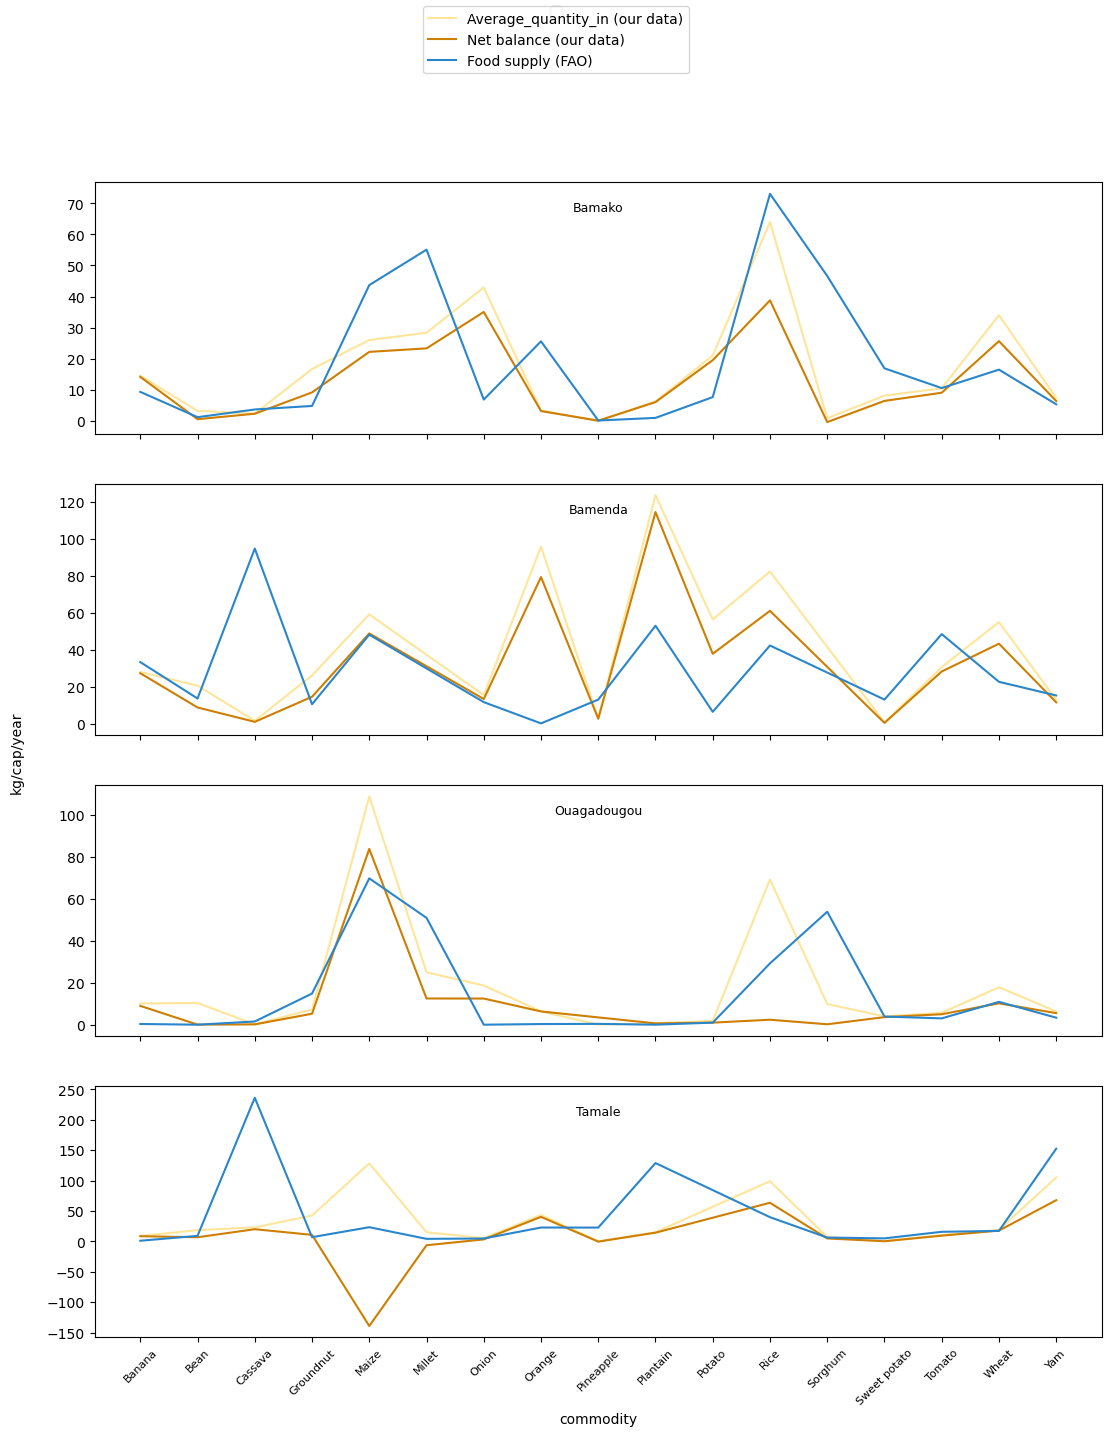

In [44]:
# balance compared with FAO food balance sheets
# selected products (item codes codes S2511, S2807, S2514, S2517, S2518, S2532, S2531, S2533, S2535, S2546, 
# S2552, S2601, S2602, S2611, S2615, S2616, S2618), BF: 2014, Ghana: 2014, Mali: 2016, Cameroon: 2017

df_food_balance_sheet=pd.read_csv("C:/Users/hanna/Documents/papers/UBC/Inputs/data_paper/data/FAO_food_balance_sheet.csv", delimiter=';')
df_food_balance_sheet['Food supply (FAO)']=df_food_balance_sheet['Value']

# summarise wheat and wheat flour

df_incoming.loc[df_incoming['commodity_name_gen']=='Wheat flour', 'commodity_name_gen'] = 'Wheat'
df_outgoing.loc[df_outgoing['commodity_name_gen']=='Wheat flour', 'commodity_name_gen'] = 'Wheat'

df_incoming_agg=df_incoming.groupby(by=['city', 'population', 'season', 'year', 'commodity_name_gen'], as_index= False)['daily_quantity_adjusted_for_missing_locations'].sum()
df_outgoing_agg=df_outgoing.groupby(by=['city', 'population', 'season', 'year', 'commodity_name_gen'], as_index= False)['daily_quantity_adjusted_for_missing_locations'].sum()

# our data
# in

df_incoming_agg['kg_cap_year']=df_incoming_agg['daily_quantity_adjusted_for_missing_locations']/df_incoming_agg['population']*365
df_outgoing_agg['kg_cap_year']=df_outgoing_agg['daily_quantity_adjusted_for_missing_locations']/df_outgoing_agg['population']*365

# Tamale: average season
df_incoming_agg_tle=df_incoming_agg[df_incoming_agg['city']=='Tamale']
df_incoming_agg_tle_average_season=df_incoming_agg_tle.groupby(by=['city', 'population', 'season',  'commodity_name_gen'], as_index= False)['kg_cap_year'].mean()

# other cities
df_incoming_agg_other=df_incoming_agg[(df_incoming_agg['city']=='Ouagadougou') | (df_incoming_agg['city']=='Bamako') | (df_incoming_agg['city']=='Bamenda')]
df_incoming_agg_all=pd.concat([df_incoming_agg_tle_average_season, df_incoming_agg_other])
df_incoming_agg_average=df_incoming_agg_all.groupby(by=['city', 'population','commodity_name_gen'], as_index= False)['kg_cap_year'].mean()
df_incoming_agg_average['Average_quantity_in (our data)']=df_incoming_agg_average['kg_cap_year']

# out

df_outgoing_agg['kg_cap_year']=df_outgoing_agg['daily_quantity_adjusted_for_missing_locations']/df_outgoing_agg['population']*365
df_outgoing_agg['kg_cap_year']=df_outgoing_agg['daily_quantity_adjusted_for_missing_locations']/df_outgoing_agg['population']*365

# Tamale: average season
df_outgoing_agg_tle=df_outgoing_agg[df_outgoing_agg['city']=='Tamale']
df_outgoing_agg_tle_average_season=df_outgoing_agg_tle.groupby(by=['city', 'population', 'season',  'commodity_name_gen'], as_index= False)['kg_cap_year'].mean()

# other cities
df_outgoing_agg_other=df_outgoing_agg[(df_outgoing_agg['city']=='Ouagadougou') | (df_outgoing_agg['city']=='Bamako') | (df_outgoing_agg['city']=='Bamenda')]
df_outgoing_agg_all=pd.concat([df_outgoing_agg_tle_average_season, df_outgoing_agg_other])
df_outgoing_agg_average=df_outgoing_agg_all.groupby(by=['city', 'population','commodity_name_gen'], as_index= False)['kg_cap_year'].mean()
df_outgoing_agg_average['Average_quantity_out (our data)']=df_outgoing_agg_average['kg_cap_year']

# balance

df_in_out_agg_average=pd.merge(df_incoming_agg_average, df_outgoing_agg_average, how='left', on=['city', 'commodity_name_gen'])
df_in_out_agg_average['Net balance (our data)']=df_in_out_agg_average['Average_quantity_in (our data)']-df_in_out_agg_average['Average_quantity_out (our data)']

df_in_out_agg_average['Item Code (CPC)']=''
df_in_out_agg_average['Area Code (M49)']=999
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Wheat', 'Item Code (CPC)'] = 'S2511'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Rice', 'Item Code (CPC)'] = 'S2807'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Maize', 'Item Code (CPC)'] = 'S2514'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Millet', 'Item Code (CPC)'] = 'S2517'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Sorghum', 'Item Code (CPC)'] = 'S2518'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Cassava', 'Item Code (CPC)'] = 'S2532'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Potato', 'Item Code (CPC)'] = 'S2531'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Sweet potato', 'Item Code (CPC)'] = 'S2533'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Yam', 'Item Code (CPC)'] = 'S2535'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Bean', 'Item Code (CPC)'] = 'S2546'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Groundnut', 'Item Code (CPC)'] = 'S2552'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Onion', 'Item Code (CPC)'] = 'S2602'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Tomato', 'Item Code (CPC)'] = 'S2601'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Orange', 'Item Code (CPC)'] = 'S2611'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Banana', 'Item Code (CPC)'] = 'S2615'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Plantain', 'Item Code (CPC)'] = 'S2616'
df_in_out_agg_average.loc[df_in_out_agg_average['commodity_name_gen']=='Pineapple', 'Item Code (CPC)'] = 'S2618'

df_in_out_agg_average.loc[df_in_out_agg_average['city']=='Tamale', 'Area Code (M49)'] = 288
df_in_out_agg_average.loc[df_in_out_agg_average['city']=='Ouagadougou', 'Area Code (M49)'] = 854
df_in_out_agg_average.loc[df_in_out_agg_average['city']=='Bamako', 'Area Code (M49)'] = 466
df_in_out_agg_average.loc[df_in_out_agg_average['city']=='Bamenda', 'Area Code (M49)'] = 120

join_data_balance_with_FAO_food_balance=pd.merge(df_in_out_agg_average, df_food_balance_sheet, how='inner', on=["Item Code (CPC)", "Area Code (M49)"])

# variation in %
join_data_balance_with_FAO_food_balance['variation_percent']=(join_data_balance_with_FAO_food_balance['Net balance (our data)']-join_data_balance_with_FAO_food_balance['Food supply (FAO)'])*100/join_data_balance_with_FAO_food_balance['Net balance (our data)']
join_data_balance_with_FAO_food_balance.head()

# plot
join_data_balance_with_FAO_food_balance_melt=join_data_balance_with_FAO_food_balance.melt(id_vars=['city', 'commodity_name_gen'], value_vars=['Average_quantity_in (our data)', 'Net balance (our data)', 'Food supply (FAO)'])
join_data_balance_with_FAO_food_balance['city'].unique()

palette={'Average_quantity_in (our data)': "#ffe599", 'Net balance (our data)': "#ce7e00", 'Food supply (FAO)': "#2986cc"}

fig, axs = plt.subplots(4, sharex=True, figsize=(13, 15))
for count, city in enumerate(join_data_balance_with_FAO_food_balance_melt['city'].unique()):
    join_data_balance_with_FAO_food_balance_melt_city=join_data_balance_with_FAO_food_balance_melt[join_data_balance_with_FAO_food_balance_melt['city']==city]
    sns.lineplot(data=join_data_balance_with_FAO_food_balance_melt_city, x='commodity_name_gen', y='value', hue='variable', ax=axs[count], palette=palette)
    axs[count].axes.get_yaxis().get_label().set_visible(False)
    axs[count].set_title(city, x=0.5, y=0.85, size=9)
    plt.xticks(fontsize=8, rotation=45)
    fig.supylabel('kg/cap/year', x=0.06, size=10)
    axs[count].legend([],[], frameon=False)
    handles, labels = axs[3].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')
plt.xlabel('commodity')
plt.show()